# Analysis of unique pathways in each database

This notebook shows explores the pathways without any type of mapping with other database (KEGG, Reactome, or WikiPathways). Summary can be found at the bottom of the notebook.

Author: [Daniel Domingo-Fernández](https://github.com/ddomingof)

In [1]:
import pandas as pd
from bio2bel_reactome.manager import Manager as ReactomeManager
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

In [2]:
%matplotlib inline

Load Established Mappings

In [3]:
kegg_wikipathways_df = pd.read_excel(
    'https://github.com/ComPath/curation/raw/master/mappings/kegg_wikipathways.xlsx',
    index_col=0
)
kegg_reactome_df = pd.read_excel(
    'https://github.com/ComPath/curation/raw/master/mappings/kegg_reactome.xlsx',
    index_col=0
)
wikipathways_reactome_df = pd.read_excel(
    'https://github.com/ComPath/curation/raw/master/mappings/wikipathways_reactome.xlsx',
    index_col=0
)

Call the Database Managers to list of reactome pathways

In [4]:
reactome_manager = ReactomeManager()

Methods to process the mapping files

In [5]:
 def get_pathways_without_mappings(all_pathways_ids, mappings_1, mappings_2):
    """Return pathways without mappings."""
    return {
        pathway_id
        for pathway_id in all_pathways_ids
        if pathway_id not in mappings_1 and pathway_id not in mappings_2
    }

def get_pathways_from_statement(mapping_statement, mapping_type):
    """Return the subject, object of the mapping.
    
    :param str mapping_statement: statement
    :param str mapping_type: type of relationship
    :rtype: tuple[str,str]
    """
    _pathways = mapping_statement.split(mapping_type)
        
    return _pathways[0].strip(), _pathways[1].strip()


def remove_star_from_pathway_name(pathway_name):
    """Remove the star that label the reference pathway in isPartOf statements.
    
    :param str statements: pathway name
    """
    return pathway_name.replace("*", "").strip()

    
def get_pathways_from_is_part_of_mapping(mapping_statement):
    """Return the pathways of a hierarchical mapping."""

    pathway_1, pathway_2 = get_pathways_from_statement(mapping_statement, 'isPartOf')

    if "*" in pathway_1:
        pathway_1 = remove_star_from_pathway_name(pathway_1)
        return pathway_1, pathway_2

    else:
        pathway_2 = remove_star_from_pathway_name(pathway_2)
        return pathway_2, pathway_1


def get_mapped_pathways(df):
    """Get pathways with mappings.
    
    :param pandas.DataFrame df: dataframe mappings
    :returns: pathways with mappings for each db
    :rtype: tuple(set, set, set)
    """
    
    reference_pathways_with_mapping = set()
    compared_pathways_with_mapping = set()
    
    row_pathways = set()
    
    for index, row in df.iterrows(): 
        
        row_pathways.add(index)

        equivalent_to_mappings = row['equivalentTo Mappings']

        if not pd.isnull(equivalent_to_mappings):

            for mapping_statement in equivalent_to_mappings.split("\n"):

                if mapping_statement == '':
                    continue

                reference_pathway, compared_pathway = get_pathways_from_statement(mapping_statement, "equivalentTo")
                
                reference_pathways_with_mapping.add(reference_pathway)
                compared_pathways_with_mapping.add(compared_pathway)

        is_part_of_mappings = row['isPartOf Mappings']

        if not pd.isnull(is_part_of_mappings):
        
            for mapping_statement in is_part_of_mappings.split('\n'):

                if mapping_statement == '':
                    continue

                reference_pathway, compared_pathway = get_pathways_from_is_part_of_mapping(mapping_statement)

                reference_pathways_with_mapping.add(reference_pathway)
                compared_pathways_with_mapping.add(compared_pathway)
                 
    return reference_pathways_with_mapping, compared_pathways_with_mapping, row_pathways


Get the pathways with mappings


In [6]:
kegg_wikipathways, wikipathways_kegg, keggs = get_mapped_pathways(kegg_wikipathways_df)

kegg_reactome, reactome_kegg, keggs = get_mapped_pathways(kegg_reactome_df)

wikipathways_reactome, reactome_wikipathways, wikipathways = get_mapped_pathways(wikipathways_reactome_df)

Get all pathways for each db

In [7]:
kegg_names = keggs # rows of the excel
reactome_names = set(reactome_manager.get_all_pathway_names()) # Get all reactome names from db
wikipathways_names = wikipathways # rows of the excel

Filter out the pathways without mappings

In [8]:
kegg_without_mappings = kegg_names.difference(kegg_reactome.union(kegg_wikipathways))
reactome_without_mappings = reactome_names.difference(reactome_wikipathways.union(reactome_kegg))
wikipathways_without_mappings = wikipathways_names.difference(wikipathways_kegg.union(wikipathways_reactome))

In [9]:
print('{} KEGG pathways do not contain any mapping'.format(len(kegg_without_mappings)))
print('{} Reactome pathways do not contain any mapping'.format(len(reactome_without_mappings)))
print('{} WikiPathways pathways do not contain any mapping'.format(len(wikipathways_without_mappings)))

84 KEGG pathways do not contain any mapping
1549 Reactome pathways do not contain any mapping
150 WikiPathways pathways do not contain any mapping


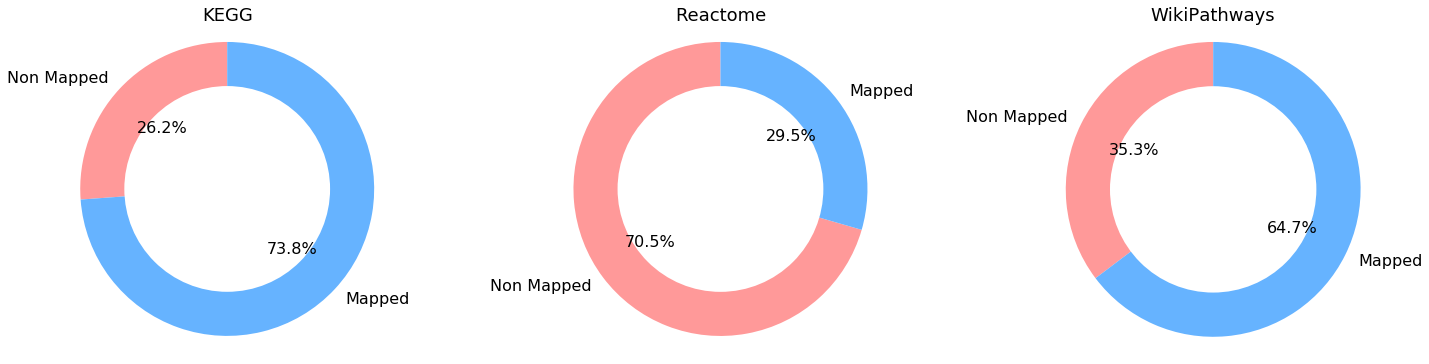

In [10]:
# Pie chart
labels = ['Non Mapped', 'Mapped']
#colors
colors = ['#ff9999','#66b3ff']
 
kegg = [26.15, 73.84] # KEGG 
reactome = [70.51, 29.48] #Reactome
wikipathways = [35.29, 64.70] #WikiPathways

fig = plt.figure(figsize=(25, 6))

mpl.rcParams['font.size'] = 16

ax1 = fig.add_subplot(1, 3, 1)

ax1.pie(kegg, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.set_title('KEGG', fontsize=18)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  

ax_2 = fig.add_subplot(1, 3, 2)

ax_2.pie(reactome, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)
ax_2.set_title('Reactome', fontsize=18)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax_2.axis('equal')  

ax_3 = fig.add_subplot(1, 3, 3)

ax_3.pie(wikipathways, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)
ax_3.set_title('WikiPathways', fontsize=18)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax_3.axis('equal')  

plt.show()

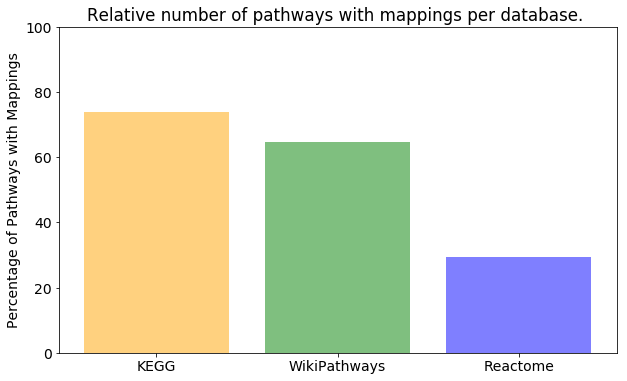

In [12]:
fig = plt.figure(figsize=(10, 6))

mpl.rcParams['font.size'] = 14

labels = ['KEGG', 'WikiPathways', 'Reactome']
data =   [73.84, 64.70, 29.48]

y_pos = np.arange(len(labels))
 
plt.bar(y_pos, data, align='center', alpha=0.5, color = ['orange', 'green', 'blue'])
plt.xticks(y_pos, labels)
plt.ylabel('Percentage of Pathways with Mappings')
plt.title('Relative number of pathways with mappings per database. ')
plt.ylim([0,100])
 
plt.show()

__Findings and Summary__:

1. __There are no metabolic pathways without mappings__. This is likely due to:
    - Metabolic knowledge is well covered in all databases
    - Reactome and KEGG both contain a big "metabolism pathway". Therefore, even there always exist a mapping.
2. __Most of the KEGG pathways without mappings correspond to disease pathways__. For example: Acute myeloid leukemia - Homo sapiens (human), Asthma - Homo sapiens (human) or Chagas disease (American trypanosomiasis) - Homo sapiens (human).

3. __A big majority (~75%) of the Reactome do not contain any mapping__. This is likely due to:
    - Reactome granularity. The majority of Reactome pathways are specific ([see linked notebook](https://github.com/ComPath/curation/blob/master/notebooks/Similarity%20analysis%20in%20mapped%20pathways.ipynb)). Therefore, it is hard to map with KEGG and WikiPathways pathways.
    - The way in which the curation protocol was conducted ([see README file](https://github.com/ComPath/curation/blob/master/README.rst)) makes more difficult to identify mappings in Reactome since it was not used as reference database but as a comparison. In other words, we curated for each KEGG pathway the possible Reactome mapping, not the other around (due to the size of Reactome) and therefore, it is possible that some mappings might not have been identified.
    
4. __Most of the WikiPathways pathways without mappings are disease-related pathways__ (e.g., 'Wnt Signaling in Kidney Disease', 'Tumor suppressor activity of SMARCB1', and 'The human immune response to tuberculosis'). In contrast to KEGG, they are not disease pathways but a variant of the pathway given a disease context.   

_If you want to see the list of pathways without mappings for each database, type in the following cell any of the three following words (depending on the database) and run the cell:_

'kegg_without_mappings', 'reactome_without_mappings', or 'wikipathways_without_mappings'